Jump to the last cell for final plot

# Lightcurve Generator

Generate BBH in AGN disk model lightcurves for a given event

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
import seaborn as sns  
from astropy.time import Time
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from matplotlib.ticker import LogLocator, FuncFormatter
import pickle

import synphot
from astropy import units as u
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import z_at_value
from astropy.modeling.physical_models import BlackBody  
from synphot.models import Empirical1D
from synphot import SourceSpectrum, SpectralElement, Observation
from synphot.models import BlackBodyNorm1D, Empirical1D
from synphot.units import PHOTLAM, FLAM
import matplotlib

import matplotlib.patches as patches
from scipy.interpolate import interp1d
from matplotlib import cm


# S250328ae

In [2]:
# Define events with start times and observation MJD times
events = {
    "S250328ae": {
        "chirp_mass": 11.96 + 9.0 - 5.84 ,
        "total_mass": 28.93 + 22.4 - 14.23,
        "dL": 492.33,
        "start": '2025-03-28 00:00:00',
        "obs_mjd": [60763., 60764., 60771., 60790.],
        "pfs_obs_mjd": [60768.],
        "obs_depths": {
            "decam1": {"z": 21.4, "r": 22.7, "i": 22.1},
            "decam2": {"z": 21.9, "r": 22.8, "i": 22.5},
            "decam3": {"z": 21.0, "r": 21.3, "i": 21.2},
            "decam4": {"z": 21.6, "r": 22.3, "i": 22.1},
            "pfs1": {"blue": 21.3, "red": 21.3, "nir": 19.6}
        },
    }
}


In [3]:
event_total_mass = [events[key]["total_mass"] for key in events.keys()]
event_total_mass = np.array(event_total_mass)
event_total_mass

array([37.1])

Compute epochs wrt to event start date

In [4]:
# Compute epochs
all_epochs = {}
for event, data in events.items():
    start_time = Time(data["start"], format='iso')
    obs_times = Time(data["obs_mjd"], format='mjd')
    all_epochs[event] = (obs_times - start_time).to_value('day')

# Print results
epochs = []
for event, ep in all_epochs.items():
    epochs.append(ep)
    print(f"{event}: {ep}")

S250328ae: [ 1.  2.  9. 28.]


In [5]:
# obs depths
obs_depths = {}
for event, data in events.items():
    obs_depths[event] = data.get("obs_depths", {})
    print(f"{event}: {obs_depths[event]}")

S250328ae: {'decam1': {'z': 21.4, 'r': 22.7, 'i': 22.1}, 'decam2': {'z': 21.9, 'r': 22.8, 'i': 22.5}, 'decam3': {'z': 21.0, 'r': 21.3, 'i': 21.2}, 'decam4': {'z': 21.6, 'r': 22.3, 'i': 22.1}, 'pfs1': {'blue': 21.3, 'red': 21.3, 'nir': 19.6}}


In [6]:
epochs

[array([ 1.,  2.,  9., 28.])]

Model functions

In [7]:
def t_ram(M_BBH, kick_velocity):
    return 20 * (M_BBH / 100) * (kick_velocity / 200)**(-3) # there is another exp in terms of G, Mbbh and vk but this is correct too

def t_diff(M_SMBH, aspect_ratio, height, optical_depth):
    diffusion_time = (
        8
        * (optical_depth / 100)
        * ( height / (aspect_ratio * 0.01))
        * (aspect_ratio / 700)
        * (M_SMBH / 10**8)
    )
    return diffusion_time

def t_end(M_SMBH, kick_velocity, aspect_ratio, height, theta):
    time_end = (
        67 
        * (kick_velocity / 200)**(-1) 
        * (aspect_ratio / 700) 
        * (M_SMBH / 10**8) 
        * (height / (aspect_ratio * 0.01))
        * (1 / np.sin(theta / 60))
    )
    return time_end

def L_BHL(M_BBH , kick_velocity, density, radiative_efficiency):
    lumi = (
        2.5 * 10**45
        * (radiative_efficiency / 0.1)
        * (M_BBH / 100)**2
        * ((kick_velocity+50) / 200)**(-3)
        * (density / 10**(-10))
    )
    return lumi

def t_exit(height, mp_optical_depth, kick_velocity):
    return (height * np.sqrt(2 * np.log(mp_optical_depth))) / kick_velocity


## Calculations

Parameters:
- Kick Velocity (vk)
- Disk Density (rho)
- Height of the disk (height) 
- Merger Point Optical Depth (mp_optical_depth)
- Angle at which BH is kicked wrt disk plane (theta)
- Mass of SMBH 
- Radiative Efficiency

Fiducial Model:
- vk: variable
- rho0: variable
- height: 700rg * 0.01 (fixed for all cases later)
- mp_optical_depth: C*rho0
- theta: 60 deg (fixed for all cases later)
- radiative_efficiency (fixed)
- mSMBH (fixed)


Note: Most important parameters here are kick velocity and density as they play a role in start and peak of the signature. Other params mostly affect the aftermath of the peak.

In [8]:
# Define the parameters for the grid
# Main Parameters
vk_array = np.array([100, 200, 300, 400, 500, 600, 700, 800])
rho_array = np.logspace(-3, -12, num=10, base=10)

# Other parameters
aspect_ratio = 700
height_array = aspect_ratio * np.array([0.01]) #[0.001, 0.01, 0.1])

C = 10**12
#mp_optical_depth = C * rho_array

theta_array = np.array([60]) #[30, 45, 60, 75])

vk_grid, rho_grid = np.meshgrid(vk_array, rho_array, indexing='ij')

# Fixed parameters
radiative_efficiency = 0.1
mSMBH = 10**8

#vk_grid, rho_grid

In [9]:
# Start times

sig_start_times = t_ram(event_total_mass, vk_grid)

peak_times = 2 * sig_start_times
peak_luminosities = L_BHL(event_total_mass, vk_grid, rho_grid, radiative_efficiency)

# End times
#exit_times = t_exit(height_grid, mp_optical_depth_grid, vk_grid)

#peak_times = np.where(peak_times > end_times, end_times, peak_times)
end_times = t_end(mSMBH, vk_grid, aspect_ratio, height_array[0], theta_array[0])

Lightcurves

In [10]:
# Define the light curve model
def gaussian_rise(rise_array, peak_lumi):
    t = rise_array 
    tg = rise_array[-1] - rise_array[0]
    t0 = rise_array[-1]
    return peak_lumi * np.exp(-((t - t0) ** 2) / (2 * tg ** 2))

def exponential_decay(fall_array, peak_lumi):
    t = fall_array 
    t0 = fall_array[0]
    te = fall_array[-1] - fall_array[0]
    return peak_lumi * np.exp(-(t - t0) / te)

def light_curve_model(times, peak_lumi):
    # Split the time array into rise and fall arrays
    rise_times = np.linspace(times[0], times[1], 100)
    fall_times = np.linspace(times[1], times[2], 100)

    rise_lumis = gaussian_rise(rise_times, peak_lumi)
    fall_lumis = exponential_decay(fall_times, peak_lumi)
    
    return rise_times, fall_times, rise_lumis, fall_lumis
    

Use solar magnitudes to obtain griz band mags

In [11]:
'''# Constants
L_sun = 3.828e33  # Solar luminosity in erg/s
M_sun = {"g": 5.12, "r": 4.64, "i": 4.53, "z": 4.50}  # Solar absolute magnitudes

# Extract distance for each event
dLs = np.array([events[key]["dL"] for key in events.keys()])  

# Function to convert luminosity to absolute magnitude
def luminosity_to_mag(L, band):
    return M_sun[band] - 2.5 * np.log10(L / L_sun)

# Function to convert absolute magnitude to apparent magnitude
def absolute_to_apparent_mag(M_band, d_L):
    return M_band + 5 * np.log10(d_L) + 25

def luminosity_to_apparant_mag(L, d_L, band):
    M_band = luminosity_to_mag(L, band)
    return absolute_to_apparent_mag(M_band, d_L)

L = np.array(peak_luminosities)  

# Compute magnitudes for each band
mags = {}

for band in ["g", "r", "i", "z"]:
    # Compute absolute magnitudes per event
    M_band = luminosity_to_mag(L, band)
    
    # Compute apparent magnitudes per event
    mags[band] = absolute_to_apparent_mag(M_band, dLs)

print("Apparent Magnitudes (griz bands):", mags)'''

'# Constants\nL_sun = 3.828e33  # Solar luminosity in erg/s\nM_sun = {"g": 5.12, "r": 4.64, "i": 4.53, "z": 4.50}  # Solar absolute magnitudes\n\n# Extract distance for each event\ndLs = np.array([events[key]["dL"] for key in events.keys()])  \n\n# Function to convert luminosity to absolute magnitude\ndef luminosity_to_mag(L, band):\n    return M_sun[band] - 2.5 * np.log10(L / L_sun)\n\n# Function to convert absolute magnitude to apparent magnitude\ndef absolute_to_apparent_mag(M_band, d_L):\n    return M_band + 5 * np.log10(d_L) + 25\n\ndef luminosity_to_apparant_mag(L, d_L, band):\n    M_band = luminosity_to_mag(L, band)\n    return absolute_to_apparent_mag(M_band, d_L)\n\nL = np.array(peak_luminosities)  \n\n# Compute magnitudes for each band\nmags = {}\n\nfor band in ["g", "r", "i", "z"]:\n    # Compute absolute magnitudes per event\n    M_band = luminosity_to_mag(L, band)\n    \n    # Compute apparent magnitudes per event\n    mags[band] = absolute_to_apparent_mag(M_band, dLs)\n\n

Use blackbody approximation for SED

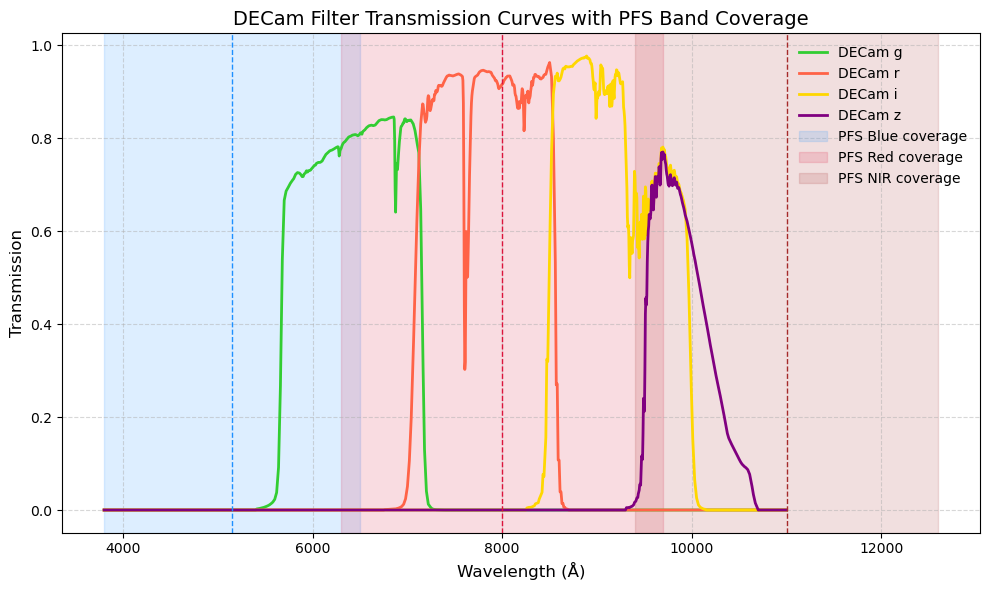

In [12]:
# Load DECam filter transmission data
bandpasses = np.loadtxt('decam_transmission_curves.txt', skiprows=1)
wav = bandpasses[:, 0] * u.AA  # Wavelengths in Angstroms
filter_g = bandpasses[:, 2]
filter_r = bandpasses[:, 3]
filter_i = bandpasses[:, 4]
filter_z = bandpasses[:, 5]

# Ensure wavelength is sorted
sort_idx = np.argsort(wav)
wav = wav[sort_idx]
filter_g = filter_g[sort_idx]
filter_r = filter_r[sort_idx]
filter_i = filter_i[sort_idx]
filter_z = filter_z[sort_idx]

# Plot DECam transmission curves
plt.figure(figsize=(10, 6))
plt.plot(wav, filter_g, label='DECam g', color='limegreen', lw=2)
plt.plot(wav, filter_r, label='DECam r', color='tomato', lw=2)
plt.plot(wav, filter_i, label='DECam i', color='gold', lw=2)
plt.plot(wav, filter_z, label='DECam z', color='purple', lw=2)

# PFS band definitions (in Angstroms)
pfs_bands = {
    'PFS Blue': {'range': (3800, 6500), 'cwl': 5150, 'color': 'dodgerblue'},
    'PFS Red': {'range': (6300, 9700), 'cwl': 8000, 'color': 'crimson'},
    'PFS NIR': {'range': (9400, 12600), 'cwl': 11000, 'color': 'brown'}
}

# Add shaded regions for PFS arms
for name, info in pfs_bands.items():
    x_min, x_max = info['range']
    plt.axvspan(x_min, x_max, color=info['color'], alpha=0.15, label=f"{name} coverage")
    plt.axvline(info['cwl'], color=info['color'], ls='--', lw=1)

# Plot formatting
plt.xlabel('Wavelength (Å)', fontsize=12)
plt.ylabel('Transmission', fontsize=12)
plt.title('DECam Filter Transmission Curves with PFS Band Coverage', fontsize=14)
plt.legend(loc='upper right', fontsize=10, frameon=False)
plt.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [13]:
# --- Unified wavelength grid (cover DECam + PFS) ---
wav_grid = np.linspace(3000, 13000, 2500) * u.AA  # 300–1300 nm range

# --- DECam Filters ---
bp_g = SpectralElement(
    Empirical1D(points=wav.value, lookup_table=filter_g),
    wave_unit=wav.unit, throughput_unit=u.dimensionless_unscaled
)
bp_r = SpectralElement(
    Empirical1D(points=wav.value, lookup_table=filter_r),
    wave_unit=wav.unit, throughput_unit=u.dimensionless_unscaled
)
bp_i = SpectralElement(
    Empirical1D(points=wav.value, lookup_table=filter_i),
    wave_unit=wav.unit, throughput_unit=u.dimensionless_unscaled
)
bp_z = SpectralElement(
    Empirical1D(points=wav.value, lookup_table=filter_z),
    wave_unit=wav.unit, throughput_unit=u.dimensionless_unscaled
)

# --- Helper: make synthetic PFS bandpasses ---
def make_pfs_band(wmin_nm, wmax_nm, wav_grid):
    """Create an idealized rectangular PFS bandpass."""
    wav = wav_grid.value  # in Å
    throughput = np.zeros_like(wav)
    mask = (wav >= wmin_nm * 10) & (wav <= wmax_nm * 10)
    throughput[mask] = 1.0  # flat response inside band
    return SpectralElement(
        Empirical1D(points=wav, lookup_table=throughput),
        wave_unit=u.AA,
        throughput_unit=u.dimensionless_unscaled
    )

# --- PFS Filters ---
bp_pfs_blue = make_pfs_band(380, 650, wav_grid)
bp_pfs_red  = make_pfs_band(630, 970, wav_grid)
bp_pfs_nir  = make_pfs_band(940, 1260, wav_grid)

# --- Combine All Filters ---
filters = {
    'g': bp_g, 'r': bp_r, 'i': bp_i, 'z': bp_z,
    'PFS_Blue': bp_pfs_blue,
    'PFS_Red': bp_pfs_red,
    'PFS_NIR': bp_pfs_nir
}

In [14]:
def effective_temperature(kick_velocity):
    return 10**5 * (kick_velocity / 100)**2

For a given kick velocity, we have a flare temperature.

The radius of the flare can be calculated by using the relationship between luminosity of the backbody and temperature.

The luminosity varies as the flare evolves for the given kick velocity.

In [15]:
def compute_bb_mags(luminosities, kick_velocity, luminosity_distance):
    temperature = effective_temperature(kick_velocity)
    radius = np.sqrt(luminosities / (4 * np.pi * 5.67e-5 * temperature**4))  # in cm?
    radius = radius * u.cm.to(u.m) * u.m  # convert to meters
    #print(f'Radius: {radius}')
    redshift = z_at_value(cosmo.luminosity_distance, luminosity_distance)
    #print(f"Redshift for dL={luminosity_distance.to(u.Mpc):.2f} is z={redshift:.3f}")
    # ensure plain float
    redshift = float(redshift)
    factors = (radius.to(u.R_sun).value / luminosity_distance.to(u.kpc).value) ** 2
    #print(f'Factors: {factors.shape}')
    results = []

    for F in factors:
        sp_bb = SourceSpectrum(BlackBodyNorm1D, temperature=temperature) * F
        flux = sp_bb(wav_grid)  
        model = Empirical1D(points=wav_grid.value,     
                        lookup_table=flux.value)   
        sp_resampled = SourceSpectrum(model,
                                wave_unit=wav_grid.unit,   
                                flux_unit=flux.unit)
        mags = {}
        for band, bp in filters.items():
            obs = Observation(sp_resampled, bp)
            mags[band] = obs.effstim('abmag').value

        results.append({'Kick velocity (km/s)': kick_velocity, 'T_eff (K)': temperature, **mags})

    df = pd.DataFrame(results)
    #print(df)

    return df

In [16]:
def compute_bb_mags_fast(luminosities, kick_velocity, luminosity_distance):
    # 1) Compute temperature and radius
    #print(f'kick_velocity: {kick_velocity}')
    temperature = effective_temperature(kick_velocity)  # scalar
    #print(f'Temperature: {temperature}') ## 
    radius = np.sqrt(luminosities / (4 * np.pi * 5.67e-5 * temperature**4))  # in cm
    radius = radius * u.cm.to(u.m) * u.m
    redshift = float(z_at_value(cosmo.luminosity_distance, luminosity_distance))

    # scaling factors for apparent flux
    factors = (radius.to(u.R_sun).value / luminosity_distance.to(u.kpc).value) ** 2

    # 2) Evaluate blackbody flux once
    sp_bb = SourceSpectrum(BlackBodyNorm1D, temperature=temperature)
    flux_bb = sp_bb(wav_grid)  # PHOTLAM

    # 3) Vectorized flux scaling
    flux_scaled = flux_bb.value[None, :] * factors[:, None]  # shape: (N_events, N_wavelengths)
    N_events = flux_scaled.shape[0]

    results = []

    for i in range(N_events):
        # Wrap into SourceSpectrum for synphot once per event
        sp_resampled = SourceSpectrum(
            Empirical1D(points=wav_grid.value, lookup_table=flux_scaled[i]),
            wave_unit=wav_grid.unit,
            flux_unit=flux_bb.unit
        )

        mags = {}
        for band, bp in filters.items():
            obs = Observation(sp_resampled, bp)
            mags[band] = obs.effstim('abmag').value

        results.append({'Luminosities': luminosities[i], 'Kick velocity (km/s)': kick_velocity,
                        'T_eff (K)': temperature, **mags})

    return pd.DataFrame(results)

# Lightcurves

With customizations specifically for PFS-DESGW paper

In [17]:
# pfs epochs
pfs_epochs = {}
for event, data in events.items():
    if "pfs_obs_mjd" in data:  # check key exists
        start_time = Time(data["start"], format='iso')
        pfs_obs_times = Time(data["pfs_obs_mjd"], format='mjd')
        pfs_epochs[event] = (pfs_obs_times - start_time).to_value('day')

# Print results
pfs_epochs_list = []
for event, ep in pfs_epochs.items():
    pfs_epochs_list.append(ep)
    print(f"{event}: {ep}")

pfs_epochs_list , pfs_epochs

S250328ae: [6.]


([array([6.])], {'S250328ae': array([6.])})

In [18]:
values_decam = [
    {"z": 21.4, "r": 22.7, "i": 22.1},
    {"z": 21.9, "r": 22.8, "i": 22.5},
    {"z": 21.0, "r": 21.3, "i": 21.2},
    {"z": 21.6, "r": 22.3, "i": 22.1},
]
values_pfs = [
    {"blue": 21.3, "red": 21.3, "nir": 19.6}
]
obs_depths_decam = dict(zip(epochs[-1], values_decam))
obs_depths_pfs = dict(zip(pfs_epochs_list[-1], values_pfs))
print("DECam Depths:", obs_depths_decam)
print("PFS Depths:", obs_depths_pfs)

DECam Depths: {1.0: {'z': 21.4, 'r': 22.7, 'i': 22.1}, 2.0: {'z': 21.9, 'r': 22.8, 'i': 22.5}, 9.0: {'z': 21.0, 'r': 21.3, 'i': 21.2}, 28.0: {'z': 21.6, 'r': 22.3, 'i': 22.1}}
PFS Depths: {6.0: {'blue': 21.3, 'red': 21.3, 'nir': 19.6}}


In [19]:
dLs = np.array([events[key]["dL"] for key in events.keys()])  
dLs

array([492.33])

In [20]:
peak_times.shape, sig_start_times.shape, end_times.shape, peak_luminosities.shape

((8, 10), (8, 10), (8, 10), (8, 10))

# Caution: This cell can take a while (>~1hr) to generate lightcurves. 

Skip this and directly load the pre-generated lightcurves pickle file in the next cell

In [21]:
'''%%time
for i, event in enumerate(events.keys()):
    model_dict = {}

    for a in range(len(vk_array)):
        for b in range(len(rho_array)):

            # ---------- Time and Luminosity Information ----------
            if peak_times[a, b] > end_times[a, b]: 
                peak_times[a, b] = end_times[a, b]

            times = np.array([
                sig_start_times[a, b],
                peak_times[a, b],
                end_times[a, b]
            ])
            #print("times:", times.shape)
            #print("peak_luminosities:", peak_luminosities[a,b].shape)

            t_rise, t_fall, lumi_rise, lumi_fall = light_curve_model(
                times, peak_luminosities[a, b]
            )

            #print(t_rise.shape, t_fall.shape, lumi_rise.shape, lumi_fall.shape)
            #print(a, b, vk_array[a], rho_array[b])
            # ---------- Conversion to magnitudes in each band ----------
            mag_rise_g = compute_bb_mags_fast(lumi_rise, vk_grid[a, b], dLs[i] * u.Mpc)['g'].to_numpy()
            mag_fall_g = compute_bb_mags_fast(lumi_fall, vk_grid[a, b], dLs[i] * u.Mpc)['g'].to_numpy()
            mag_rise_r = compute_bb_mags_fast(lumi_rise, vk_grid[a, b], dLs[i] * u.Mpc)['r'].to_numpy()
            mag_fall_r = compute_bb_mags_fast(lumi_fall, vk_grid[a, b], dLs[i] * u.Mpc)['r'].to_numpy()
            mag_rise_i = compute_bb_mags_fast(lumi_rise, vk_grid[a, b], dLs[i] * u.Mpc)['i'].to_numpy()
            mag_fall_i = compute_bb_mags_fast(lumi_fall, vk_grid[a, b], dLs[i] * u.Mpc)['i'].to_numpy()
            mag_rise_z = compute_bb_mags_fast(lumi_rise, vk_grid[a, b], dLs[i] * u.Mpc)['z'].to_numpy()
            mag_fall_z = compute_bb_mags_fast(lumi_fall, vk_grid[a, b], dLs[i] * u.Mpc)['z'].to_numpy()
            mag_rise_pfs_blue = compute_bb_mags_fast(lumi_rise, vk_grid[a, b], dLs[i] * u.Mpc)['PFS_Blue'].to_numpy()
            mag_fall_pfs_blue = compute_bb_mags_fast(lumi_fall, vk_grid[a, b], dLs[i] * u.Mpc)['PFS_Blue'].to_numpy()
            mag_rise_pfs_red = compute_bb_mags_fast(lumi_rise, vk_grid[a, b], dLs[i] * u.Mpc)['PFS_Red'].to_numpy()
            mag_fall_pfs_red = compute_bb_mags_fast(lumi_fall, vk_grid[a, b], dLs[i] * u.Mpc)['PFS_Red'].to_numpy()
            mag_rise_pfs_nir = compute_bb_mags_fast(lumi_rise, vk_grid[a, b], dLs[i] * u.Mpc)['PFS_NIR'].to_numpy()
            mag_fall_pfs_nir = compute_bb_mags_fast(lumi_fall, vk_grid[a, b], dLs[i] * u.Mpc)['PFS_NIR'].to_numpy()

            # ---------- Combine rise and fall parts ----------
            time_g = np.concatenate([t_rise, t_fall])
            mag_g = np.concatenate([mag_rise_g, mag_fall_g])
            time_r = np.concatenate([t_rise, t_fall])
            mag_r = np.concatenate([mag_rise_r, mag_fall_r])
            time_i = np.concatenate([t_rise, t_fall])
            mag_i = np.concatenate([mag_rise_i, mag_fall_i])
            time_z = np.concatenate([t_rise, t_fall])
            mag_z = np.concatenate([mag_rise_z, mag_fall_z])
            time_pfs_blue = np.concatenate([t_rise, t_fall])
            mag_pfs_blue = np.concatenate([mag_rise_pfs_blue, mag_fall_pfs_blue])
            time_pfs_red = np.concatenate([t_rise, t_fall])
            mag_pfs_red = np.concatenate([mag_rise_pfs_red, mag_fall_pfs_red])
            time_pfs_nir = np.concatenate([t_rise, t_fall])
            mag_pfs_nir = np.concatenate([mag_rise_pfs_nir, mag_fall_pfs_nir])  

            # ---------- Sort by time ----------
            idx_g = np.argsort(time_g)
            idx_r = np.argsort(time_r)
            idx_i = np.argsort(time_i)
            idx_z = np.argsort(time_z)
            idx_pfs_blue = np.argsort(time_pfs_blue)
            idx_pfs_red = np.argsort(time_pfs_red)
            idx_pfs_nir = np.argsort(time_pfs_nir)

            # ---------- Save this model's data ----------

            def scientific_to_latex(val):
                """Convert float in scientific notation to LaTeX-friendly 10^x format."""
                exponent = int(np.floor(np.log10(abs(val))))
                base = val / 10**exponent
                # Round base if needed (often it's 1.0 so you can omit)
                if np.isclose(base, 1.0):
                    return f"10^{{{exponent}}}"
                else:
                    return f"{base:.1f} \\times 10^{{{exponent}}}"

            rho_val = rho_array[b]
            rho_str = scientific_to_latex(rho_val)
            model_id = (
                        f"$v_k={vk_array[a]}km/s$\n"
                        f"$\\rho={rho_str}g/cm^3$\n"
                    )

            model_dict[model_id] = {
                'g': (time_g[idx_g], mag_g[idx_g]),
                'r': (time_r[idx_r], mag_r[idx_r]),
                'i': (time_i[idx_i], mag_i[idx_i]),
                'z': (time_z[idx_z], mag_z[idx_z]),
                'PFS_Blue': (time_pfs_blue[idx_pfs_blue], mag_pfs_blue[idx_pfs_blue]),
                'PFS_Red': (time_pfs_red[idx_pfs_red], mag_pfs_red[idx_pfs_red]),
                'PFS_NIR': (time_pfs_nir[idx_pfs_nir], mag_pfs_nir[idx_pfs_nir]),
                'params': {
                    'vk': vk_array[a],
                    'rho': rho_array[b],
                }
            }
    model_dict['event'] = event
    model_dict['start'] = events[event]["start"]
    model_dict['dL'] = events[event]["dL"]
    model_dict['chirp_mass'] = events[event]["chirp_mass"]

    # ---------- Save the full model dictionary ----------
    with open(f'model_lightcurves_dict_{event}_DECam_PFS.pkl', 'wb') as f:
        pickle.dump(model_dict, f)

    print(f"Saved model lightcurves for event {event} with {len(model_dict)} models.")'''

'%%time\nfor i, event in enumerate(events.keys()):\n    model_dict = {}\n\n    for a in range(len(vk_array)):\n        for b in range(len(rho_array)):\n\n            # ---------- Time and Luminosity Information ----------\n            if peak_times[a, b] > end_times[a, b]: \n                peak_times[a, b] = end_times[a, b]\n\n            times = np.array([\n                sig_start_times[a, b],\n                peak_times[a, b],\n                end_times[a, b]\n            ])\n            #print("times:", times.shape)\n            #print("peak_luminosities:", peak_luminosities[a,b].shape)\n\n            t_rise, t_fall, lumi_rise, lumi_fall = light_curve_model(\n                times, peak_luminosities[a, b]\n            )\n\n            #print(t_rise.shape, t_fall.shape, lumi_rise.shape, lumi_fall.shape)\n            #print(a, b, vk_array[a], rho_array[b])\n            # ---------- Conversion to magnitudes in each band ----------\n            mag_rise_g = compute_bb_mags_fast(lumi_

In [22]:
# Load one event's model dict
event = list(events.keys())[0]  
with open(f'model_lightcurves_dict_{event}_DECam_PFS.pkl', 'rb') as f:
    model_dict = pickle.load(f)

model_dict

{'$v_k=100km/s$\n$\\rho=10^{-3}g/cm^3$\n': {'g': (array([ 59.36      ,  59.95959596,  60.55919192,  61.15878788,
           61.75838384,  62.3579798 ,  62.95757576,  63.55717172,
           64.15676768,  64.75636364,  65.3559596 ,  65.95555556,
           66.55515152,  67.15474747,  67.75434343,  68.35393939,
           68.95353535,  69.55313131,  70.15272727,  70.75232323,
           71.35191919,  71.95151515,  72.55111111,  73.15070707,
           73.75030303,  74.34989899,  74.94949495,  75.54909091,
           76.14868687,  76.74828283,  77.34787879,  77.94747475,
           78.54707071,  79.14666667,  79.74626263,  80.34585859,
           80.94545455,  81.54505051,  82.14464646,  82.74424242,
           83.34383838,  83.94343434,  84.5430303 ,  85.14262626,
           85.74222222,  86.34181818,  86.94141414,  87.5410101 ,
           88.14060606,  88.74020202,  89.33979798,  89.93939394,
           90.5389899 ,  91.13858586,  91.73818182,  92.33777778,
           92.93737374,  93.5

In [23]:
# Paramter space compared to obs depths
# Find brightest (minimum) magnitude in each band
bands_decam = ['r','i','z'] 
bands_pfs = ['blue', 'red', 'nir']
brightest = {band: min(d[band] for d in values_decam) for band in bands_decam}
brightest.update({band: min(d[band] for d in values_pfs) for band in bands_pfs})

print(brightest)


{'r': 21.3, 'i': 21.2, 'z': 21.0, 'blue': 21.3, 'red': 21.3, 'nir': 19.6}


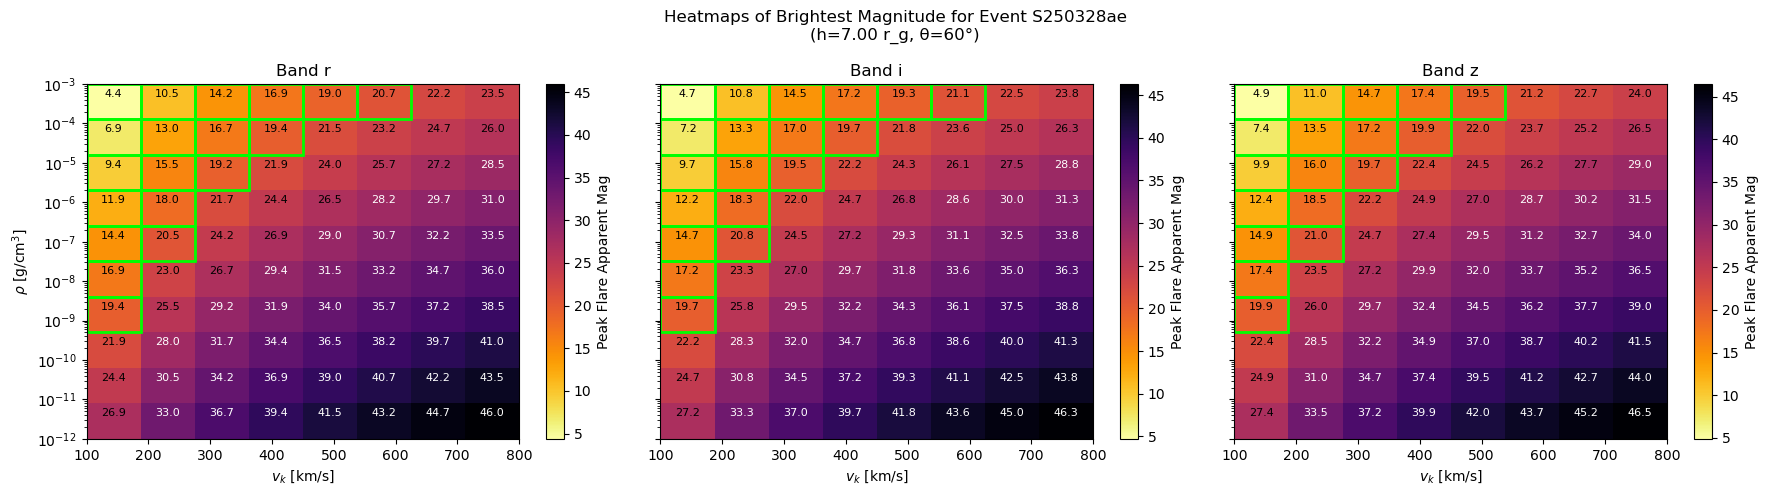

In [24]:
# filter models as needed
filtered_models = {m: model_dict[m] for m in model_dict 
                   if m not in ['event','start','dL','chirp_mass']}

vk_vals = np.array(sorted(set([filtered_models[m]['params']['vk'] for m in filtered_models])))
rho_vals = np.array(sorted(set([filtered_models[m]['params']['rho'] for m in filtered_models])))

heatmaps = {band: np.full((len(rho_vals), len(vk_vals)), np.nan) for band in bands_decam}

for model_id, data in filtered_models.items():
    vk = data['params']['vk']
    rho = data['params']['rho']
    a = np.where(vk_vals == vk)[0][0]
    b = np.where(rho_vals == rho)[0][0]
    for band in bands_decam:
        times, mags = data[band]
        heatmaps[band][b,a] = np.nanmin(mags)  # take brightest (lowest mag)


fig, axes = plt.subplots(1, 3, figsize=(18,5), sharey=True)

for i, band in enumerate(bands_decam):
    vk_edges = np.linspace(vk_vals.min(), vk_vals.max(), len(vk_vals)+1)
    rho_edges = np.logspace(np.log10(rho_vals.min()), np.log10(rho_vals.max()), len(rho_vals)+1)
    vk_grid, rho_grid = np.meshgrid(vk_edges, rho_edges)

    pcm = axes[i].pcolormesh(
        vk_grid, rho_grid, heatmaps[band],
        cmap='inferno_r', shading='auto'
    )
    
    axes[i].set_title(f'Band {band}')
    axes[i].set_xlabel(r'$v_k$ [km/s]')
    axes[i].set_yscale('log')
    if i == 0:
        axes[i].set_ylabel(r'$\rho$ [g/cm$^3$]')

    fig.colorbar(pcm, ax=axes[i], label='Peak Flare Apparent Mag')

    for row_idx in range(len(rho_vals)):
        for col_idx in range(len(vk_vals)):
            val = heatmaps[band][row_idx, col_idx]
            if np.isnan(val):
                continue
            x = (vk_edges[col_idx] + vk_edges[col_idx+1]) / 2
            y = (rho_edges[row_idx] + rho_edges[row_idx+1]) / 2
            # Text annotation
            color = 'black' if val < np.nanmedian(heatmaps[band]) else 'white'
            axes[i].text(x, y, f'{val:.1f}', ha='center', va='center', color=color, fontsize=8)
            
            if val < brightest[band]:
                rect = patches.Rectangle(
                    (vk_edges[col_idx], rho_edges[row_idx]),
                    vk_edges[col_idx+1] - vk_edges[col_idx],
                    rho_edges[row_idx+1] - rho_edges[row_idx],
                    linewidth=2, edgecolor='lime', facecolor='none'
                )
                axes[i].add_patch(rect)

plt.suptitle(f'Heatmaps of Brightest Magnitude for Event {event}\n(h=7.00 r_g, θ=60°)')
plt.tight_layout()
plt.show()

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_95036/3759835401.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('inferno_r').copy()


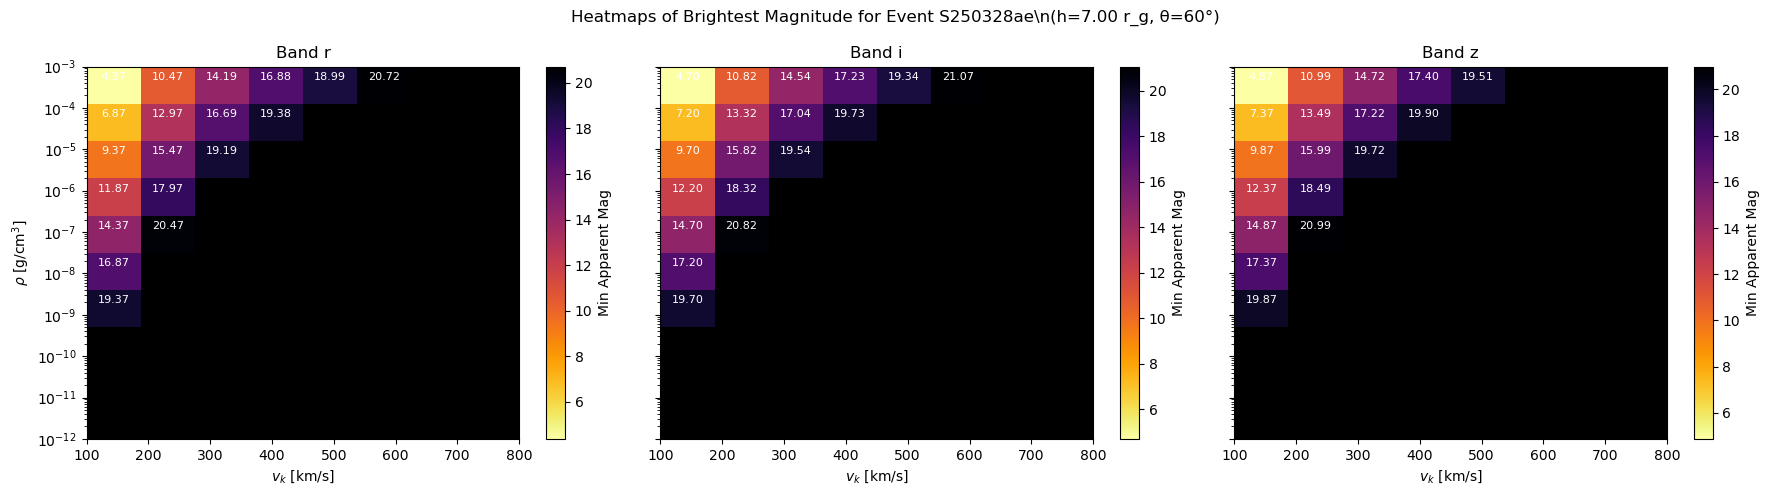

In [25]:
# filter models
filtered_models = {m: model_dict[m] for m in model_dict 
                   if m not in ['event','start','dL','chirp_mass']}

vk_vals = np.array(sorted(set([filtered_models[m]['params']['vk'] for m in filtered_models])))
rho_vals = np.array(sorted(set([filtered_models[m]['params']['rho'] for m in filtered_models])))

heatmaps = {band: np.full((len(rho_vals), len(vk_vals)), np.nan) for band in bands_decam}

for model_id, data in filtered_models.items():
    vk = data['params']['vk']
    rho = data['params']['rho']
    a = np.where(vk_vals == vk)[0][0]
    b = np.where(rho_vals == rho)[0][0]
    for band in bands_decam:
        times, mags = data[band]
        heatmaps[band][b,a] = np.nanmin(mags)  # take brightest (lowest mag)


masked_heatmaps = {}
for band in bands_decam:
    arr = heatmaps[band]
    masked_heatmaps[band] = np.ma.masked_where(arr > brightest[band], arr)

cmap = matplotlib.cm.get_cmap('inferno_r').copy()
cmap.set_bad('black')

fig, axes = plt.subplots(1, 3, figsize=(18,5), sharey=True)

for i, band in enumerate(bands_decam):
    vk_edges = np.linspace(vk_vals.min(), vk_vals.max(), len(vk_vals)+1)
    rho_edges = np.logspace(np.log10(rho_vals.min()), np.log10(rho_vals.max()), len(rho_vals)+1)
    vk_grid, rho_grid = np.meshgrid(vk_edges, rho_edges)
    pcm = axes[i].pcolormesh(
        vk_grid, rho_grid, masked_heatmaps[band],
        cmap=cmap, shading='auto'
    )
    axes[i].set_title(f'Band {band}')
    axes[i].set_xlabel(r'$v_k$ [km/s]')
    axes[i].set_yscale('log')
    if i == 0:
        axes[i].set_ylabel(r'$\rho$ [g/cm$^3$]')
    fig.colorbar(pcm, ax=axes[i], label='Min Apparent Mag')

    arr = masked_heatmaps[band]
    for b in range(arr.shape[0]):
        for a in range(arr.shape[1]):
            mag_value = arr[b, a]
            if not np.ma.is_masked(mag_value) and not np.isnan(mag_value):
                vk_center = (vk_edges[a] + vk_edges[a+1]) / 2
                rho_center = (rho_edges[b] + rho_edges[b+1]) / 2
                axes[i].text(vk_center, rho_center, f"{mag_value:.2f}",
                             ha='center', va='center', fontsize=8, color='white')

plt.suptitle(f'Heatmaps of Brightest Magnitude for Event {event}\\n(h=7.00 r_g, θ=60°)')
plt.tight_layout()
plt.show()




In [26]:
obs_depths_decam, obs_depths_pfs

({1.0: {'z': 21.4, 'r': 22.7, 'i': 22.1},
  2.0: {'z': 21.9, 'r': 22.8, 'i': 22.5},
  9.0: {'z': 21.0, 'r': 21.3, 'i': 21.2},
  28.0: {'z': 21.6, 'r': 22.3, 'i': 22.1}},
 {6.0: {'blue': 21.3, 'red': 21.3, 'nir': 19.6}})

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_95036/2403207463.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('inferno_r')


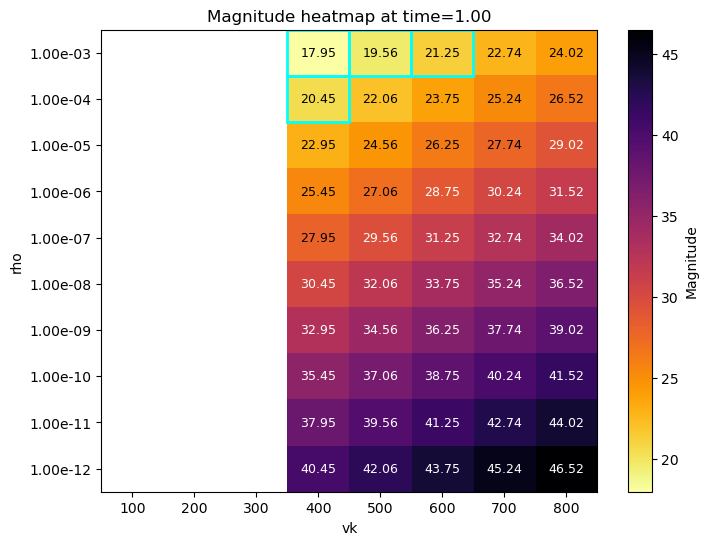

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_95036/2403207463.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('inferno_r')


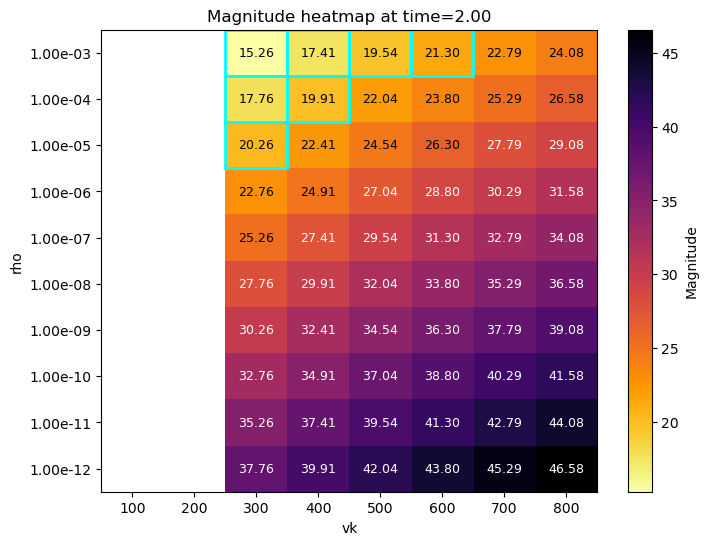

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_95036/2403207463.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('inferno_r')


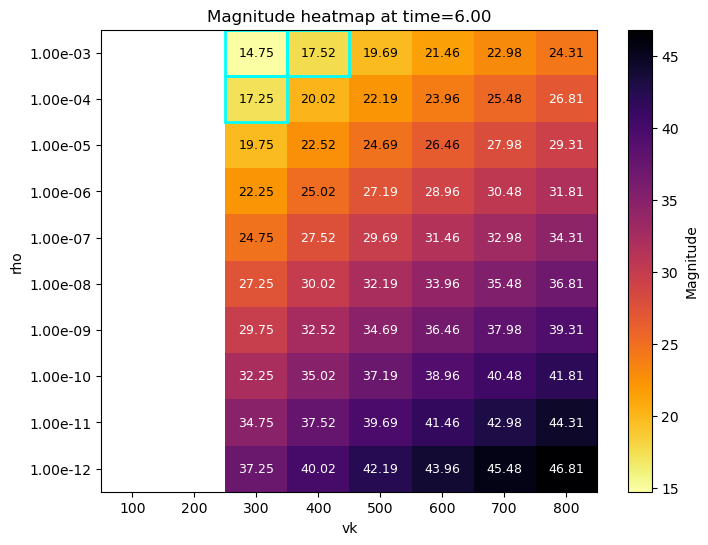

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_95036/2403207463.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('inferno_r')


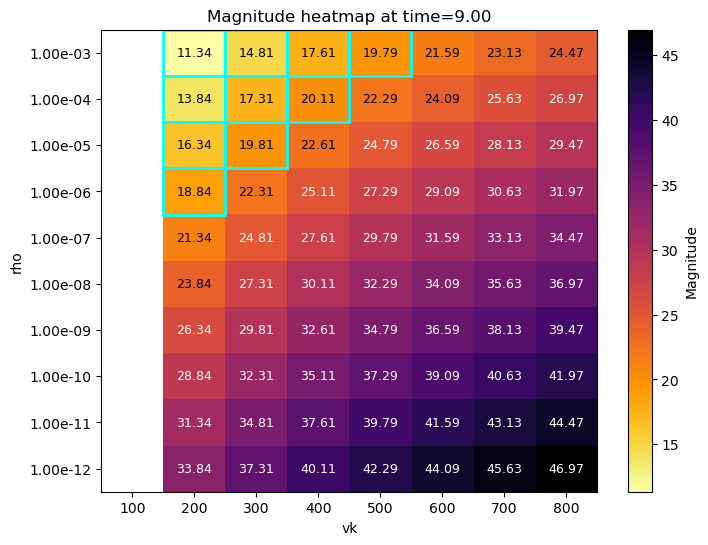

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_95036/2403207463.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('inferno_r')


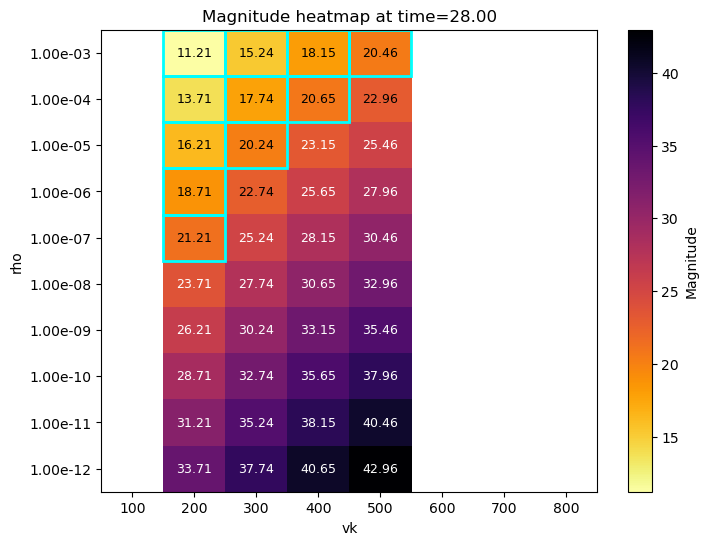

In [27]:

target_times = [1.0, 2.0, 6.0, 9.0, 28.0]
depths = [21.4, 21.9, 19.6, 21.0, 21.6]
depths_r = [22.7, 22.8, 21.3, 21.3, 22.3]
depths_i = [22.1, 22.5, 21.3, 21.2, 22.1]
tolerance = 0.2

vk_values = sorted(set(
    entry['params']['vk']
    for entry in model_dict.values()
    if isinstance(entry, dict) and 'params' in entry
))
rho_values = sorted(set(
    entry['params']['rho']
    for entry in model_dict.values()
    if isinstance(entry, dict) and 'params' in entry
))

for t_idx, t in enumerate(target_times):
    mag_matrix = np.full((len(rho_values), len(vk_values)), np.nan, dtype=float)
    
    for model_id, model in model_dict.items():
        if isinstance(model, dict) and 'z' in model:
            time_z, mag_z = model['z']
            idx = np.where(np.abs(time_z - t) < tolerance)[0]
            if len(idx) > 0:
                vk = model['params']['vk']
                rho = model['params']['rho']
                mag = mag_z[idx[0]]
                i = rho_values.index(rho)  # rho on y-axis
                j = vk_values.index(vk)    # vk on x-axis
                mag_matrix[i, j] = mag

    plt.figure(figsize=(8, 6))
    im = plt.imshow(mag_matrix, origin='lower', aspect='auto', cmap='inferno_r')
    plt.colorbar(im, label='Magnitude')
    plt.xlabel('vk')
    plt.ylabel('rho')
    plt.title(f'Magnitude heatmap at time={t:.2f}')
    plt.xticks(np.arange(len(vk_values)), [f"{val:.0f}" for val in vk_values])
    plt.yticks(np.arange(len(rho_values)), [f"{val:.2e}" for val in rho_values])

    norm = plt.Normalize(np.nanmin(mag_matrix), np.nanmax(mag_matrix))
    cmap = cm.get_cmap('inferno_r')
    ax = plt.gca()
    for i in range(len(rho_values)):
        for j in range(len(vk_values)):
            if not np.isnan(mag_matrix[i, j]):
                mag = mag_matrix[i, j]
                rgba = cmap(norm(mag))
                brightness = 0.299*rgba[0] + 0.587*rgba[1] + 0.114*rgba[2]
                text_color = 'white' if brightness < 0.5 else 'black'
                plt.text(j, i, f"{mag:.2f}", ha='center', va='center', color=text_color, fontsize=9)
                # Draw colored outline if mag is less than depth threshold for that time
                if mag < depths[t_idx]:
                    rect = patches.Rectangle((j-0.5, i-0.5), 1, 1, linewidth=2, edgecolor='cyan', facecolor='none', zorder=2)
                    ax.add_patch(rect)
    plt.show()


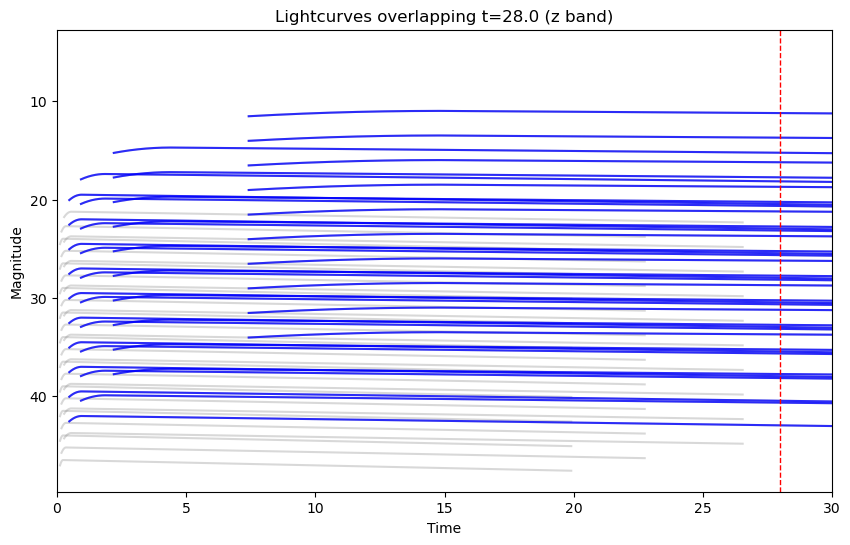

Number of lightcurves overlapping t=28.0: 40


In [28]:
target_time = 28.0
tolerance = 0.2

plt.figure(figsize=(10, 6))

count = 0

# Plot all lightcurves in gray first
for model_id, model in model_dict.items():
    if isinstance(model, dict) and 'z' in model:
        time_z, mag_z = model['z']
        plt.plot(time_z, mag_z, color='gray', alpha=0.3)

# Highlight lightcurves overlapping with the first vertical line
for model_id, model in model_dict.items():
    if isinstance(model, dict) and 'z' in model:
        time_z, mag_z = model['z']
        if any(abs(time_z - target_time) < tolerance):
            plt.plot(time_z, mag_z, color='blue', alpha=0.8)
            count += 1

# Draw the first vertical line
plt.axvline(x=target_time, color='red', linestyle='--', linewidth=1)

plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.xlim(0, 30)
plt.title(f'Lightcurves overlapping t={target_time} (z band)')
plt.gca().invert_yaxis()
plt.show()

print(f"Number of lightcurves overlapping t={target_time}: {count}")


In [29]:
target_times = [1.0, 2.0, 6.0, 9.0, 28.0]
tolerance = 0.1

overlap_counts = []

for t in target_times:
    count = 0
    for model_id, model in model_dict.items():
        if isinstance(model, dict) and 'z' in model:
            time_z, mag_z = model['z']
            if any(abs(time_z - t) < tolerance):
                count += 1
    overlap_counts.append(count)

for t, count in zip(target_times, overlap_counts):
    print(f"Number of lightcurves overlapping t={t}: {count}")


Number of lightcurves overlapping t=1.0: 50
Number of lightcurves overlapping t=2.0: 20
Number of lightcurves overlapping t=6.0: 50
Number of lightcurves overlapping t=9.0: 50
Number of lightcurves overlapping t=28.0: 30


Heatmaps for specific epochs, PFS epoch uses DECam r, i, z bands

DEcam depths are transient detection depth...

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_95036/895159254.py:80: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('inferno_r')
/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_95036/895159254.py:80: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('inferno_r')
/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_95036/895159254.py:80: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('inferno_r')
/

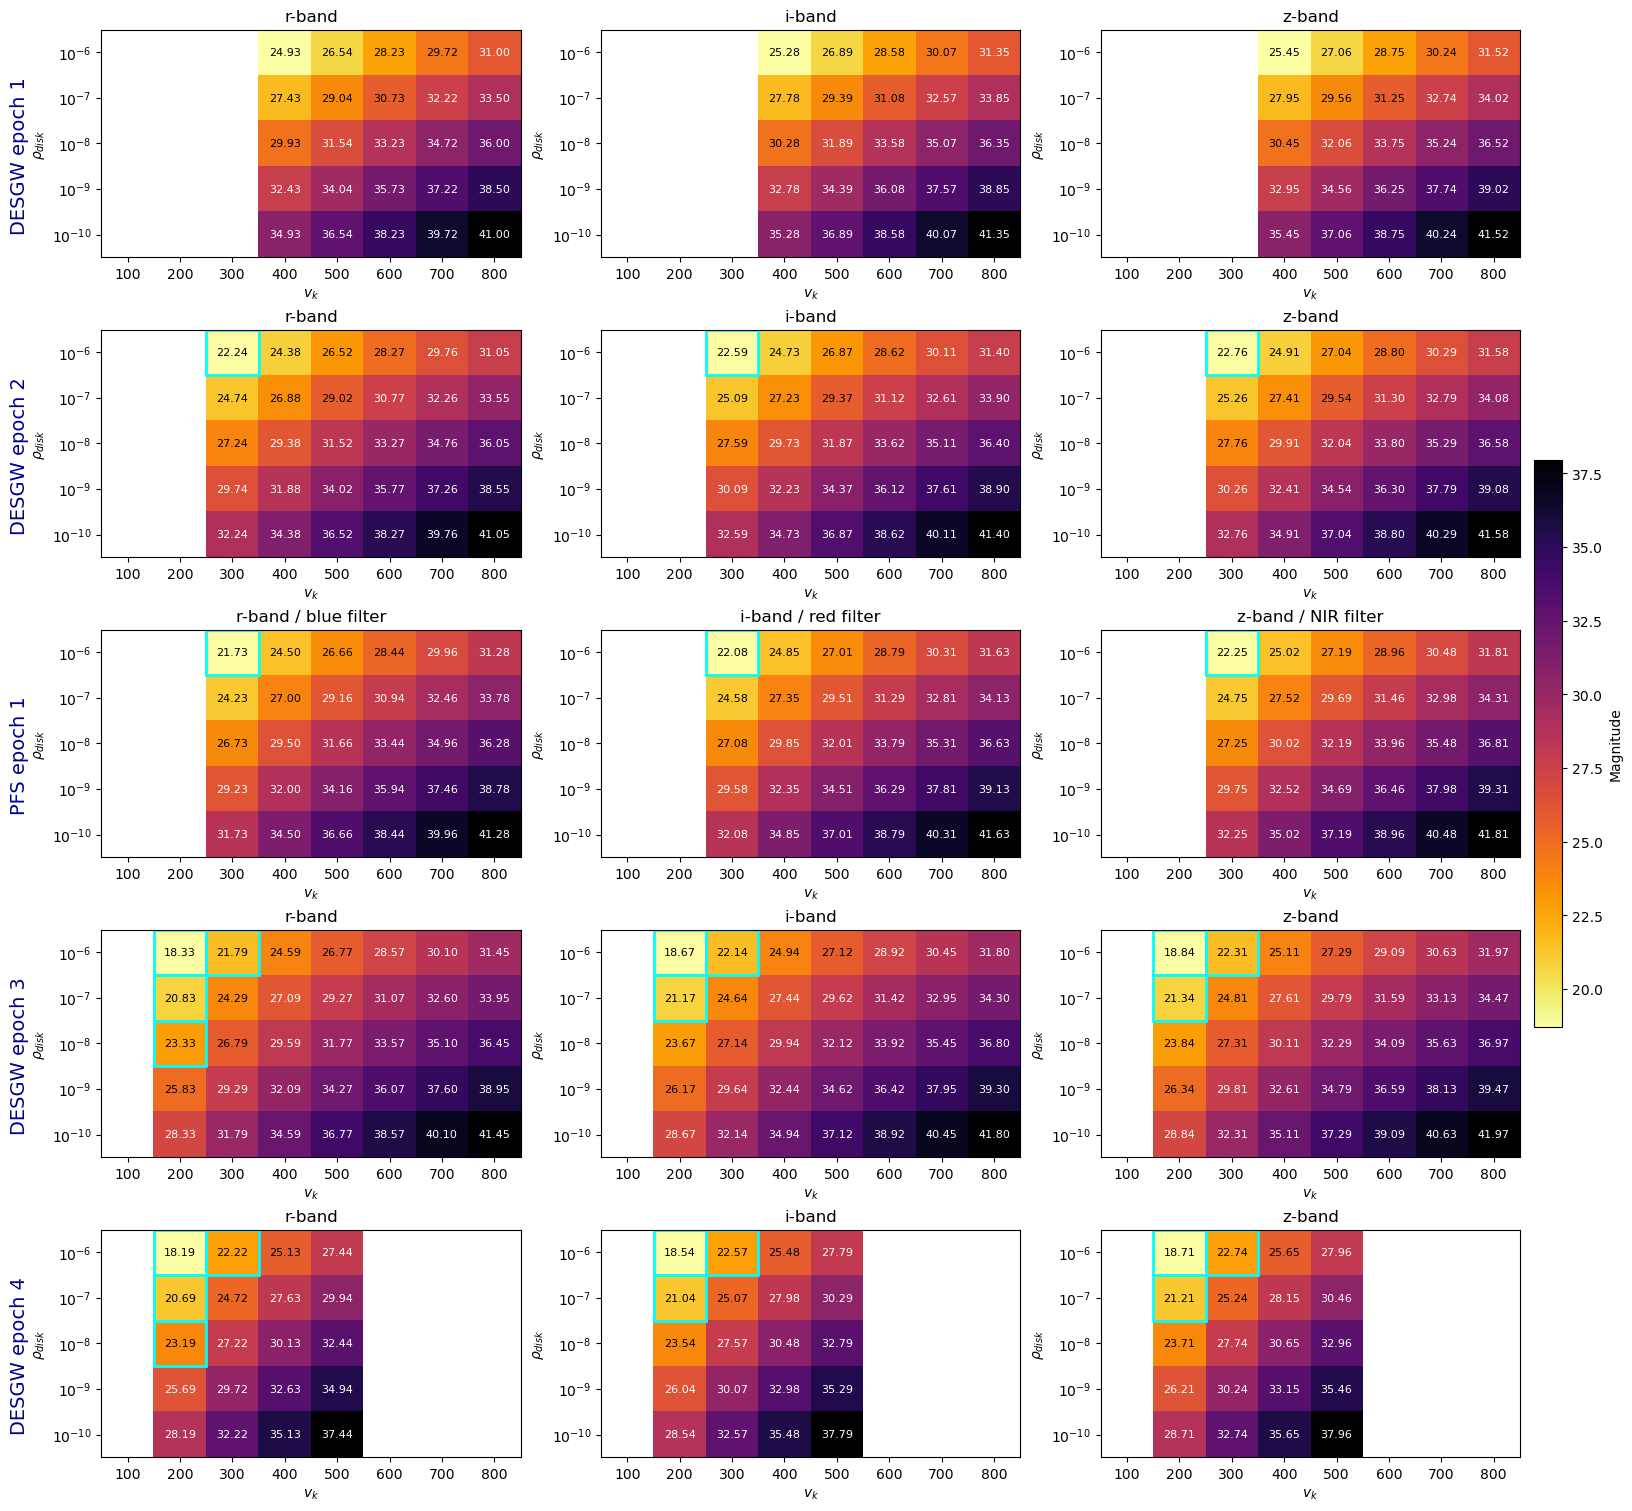

In [30]:
target_times = [1.0, 2.0, 6.0, 9.0, 28.0]
'''depths = {
    'z': [21.4, 21.9, 19.6, 21.0, 21.6],
    'r': [22.7, 22.8, 21.3, 21.3, 22.3],
    'i': [22.1, 22.5, 21.3, 21.2, 22.1]
}'''
depths = {
    'r': [23.8, 23.8, 23.8, 23.8, 23.8],
    'i': [23.5, 23.5, 23.5, 23.5, 23.5],
    'z': [23.4, 23.4, 23.4, 23.4, 23.4]
}

#r ∼ 23.8, i ∼ 23.5, and z ∼ 23.4

bands = ['r', 'i', 'z']
tolerance = 0.2

vk_values = sorted(set(
    entry['params']['vk']
    for entry in model_dict.values()
    if isinstance(entry, dict) and 'params' in entry
))
rho_values = sorted(set(
    entry['params']['rho']
    for entry in model_dict.values()
    if isinstance(entry, dict) and 'params' in entry
))

# Filter rho values to the range of interest
rho_min = 1e-10
rho_max = 1e-6
filtered_rho_values = [rho for rho in rho_values if rho_min <= rho <= rho_max]


def format_rho(rho):
    exp = int(np.floor(np.log10(rho)))
    return f"$10^{{{exp}}}$"

fig, axes = plt.subplots(len(target_times), len(bands), figsize=(16, 3*len(target_times)), constrained_layout=True)

row_labels = ["DESGW epoch 1", "DESGW epoch 2", "PFS epoch 1", "DESGW epoch 3", "DESGW epoch 4"]

custom_titles = {
    'r': "r-band / blue filter",
    'i': "i-band / red filter",
    'z': "z-band / NIR filter"
}

for t_idx, t in enumerate(target_times):
    for b_idx, band in enumerate(bands):
        mag_matrix = np.full((len(filtered_rho_values), len(vk_values)), np.nan, dtype=float)
        for model_id, model in model_dict.items():
            if isinstance(model, dict) and band in model:
                time_b, mag_b = model[band]
                idx = np.where(np.abs(time_b - t) < tolerance)[0]
                if len(idx) > 0:
                    vk = model['params']['vk']
                    rho = model['params']['rho']
                    mag = mag_b[idx[0]]
                    if rho_min <= rho <= rho_max:
                        i = filtered_rho_values.index(rho)
                        j = vk_values.index(vk)
                        mag_matrix[i, j] = mag

        ax = axes[t_idx, b_idx] if len(target_times) > 1 else axes[b_idx]
        im = ax.imshow(mag_matrix, origin='lower', aspect='auto', cmap='inferno_r')
        ax.set_xlabel(r'$v_k$')
        ax.set_ylabel(r'$\rho_{disk}$')
        # Set custom titles for PFS epoch row
        if t_idx == 2:
            ax.set_title(custom_titles[band])
        else:
            ax.set_title(f'{band}-band')
        ax.set_xticks(np.arange(len(vk_values)))
        ax.set_xticklabels([f"{val:.0f}" for val in vk_values])
        ax.set_yticks(np.arange(len(filtered_rho_values)))
        ax.set_yticklabels([format_rho(val) for val in filtered_rho_values])

        norm = plt.Normalize(np.nanmin(mag_matrix), np.nanmax(mag_matrix))
        cmap = cm.get_cmap('inferno_r')
        for i in range(len(filtered_rho_values)):
            for j in range(len(vk_values)):
                if not np.isnan(mag_matrix[i, j]):
                    mag = mag_matrix[i, j]
                    rgba = cmap(norm(mag))
                    brightness = 0.299*rgba[0] + 0.587*rgba[1] + 0.114*rgba[2]
                    text_color = 'white' if brightness < 0.5 else 'black'
                    ax.text(j, i, f"{mag:.2f}", ha='center', va='center', color=text_color, fontsize=8)
                    if mag < depths[band][t_idx]:
                        rect = patches.Rectangle((j-0.5, i-0.5), 1, 1, linewidth=2, edgecolor='cyan', facecolor='none', zorder=2)
                        ax.add_patch(rect)
    # Add row label (epoch) to the left of the row of subplots
    fig.text(0.001, 1 - (t_idx + 0.5) / len(target_times), row_labels[t_idx], va='center', ha='right', fontsize=14, color='darkblue', rotation=90)

fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.01, label='Magnitude')
plt.show()


Same as above but restricted axes ranges

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_95036/1873931157.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('inferno_r')
/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_95036/1873931157.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('inferno_r')
/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_95036/1873931157.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('inferno_r'

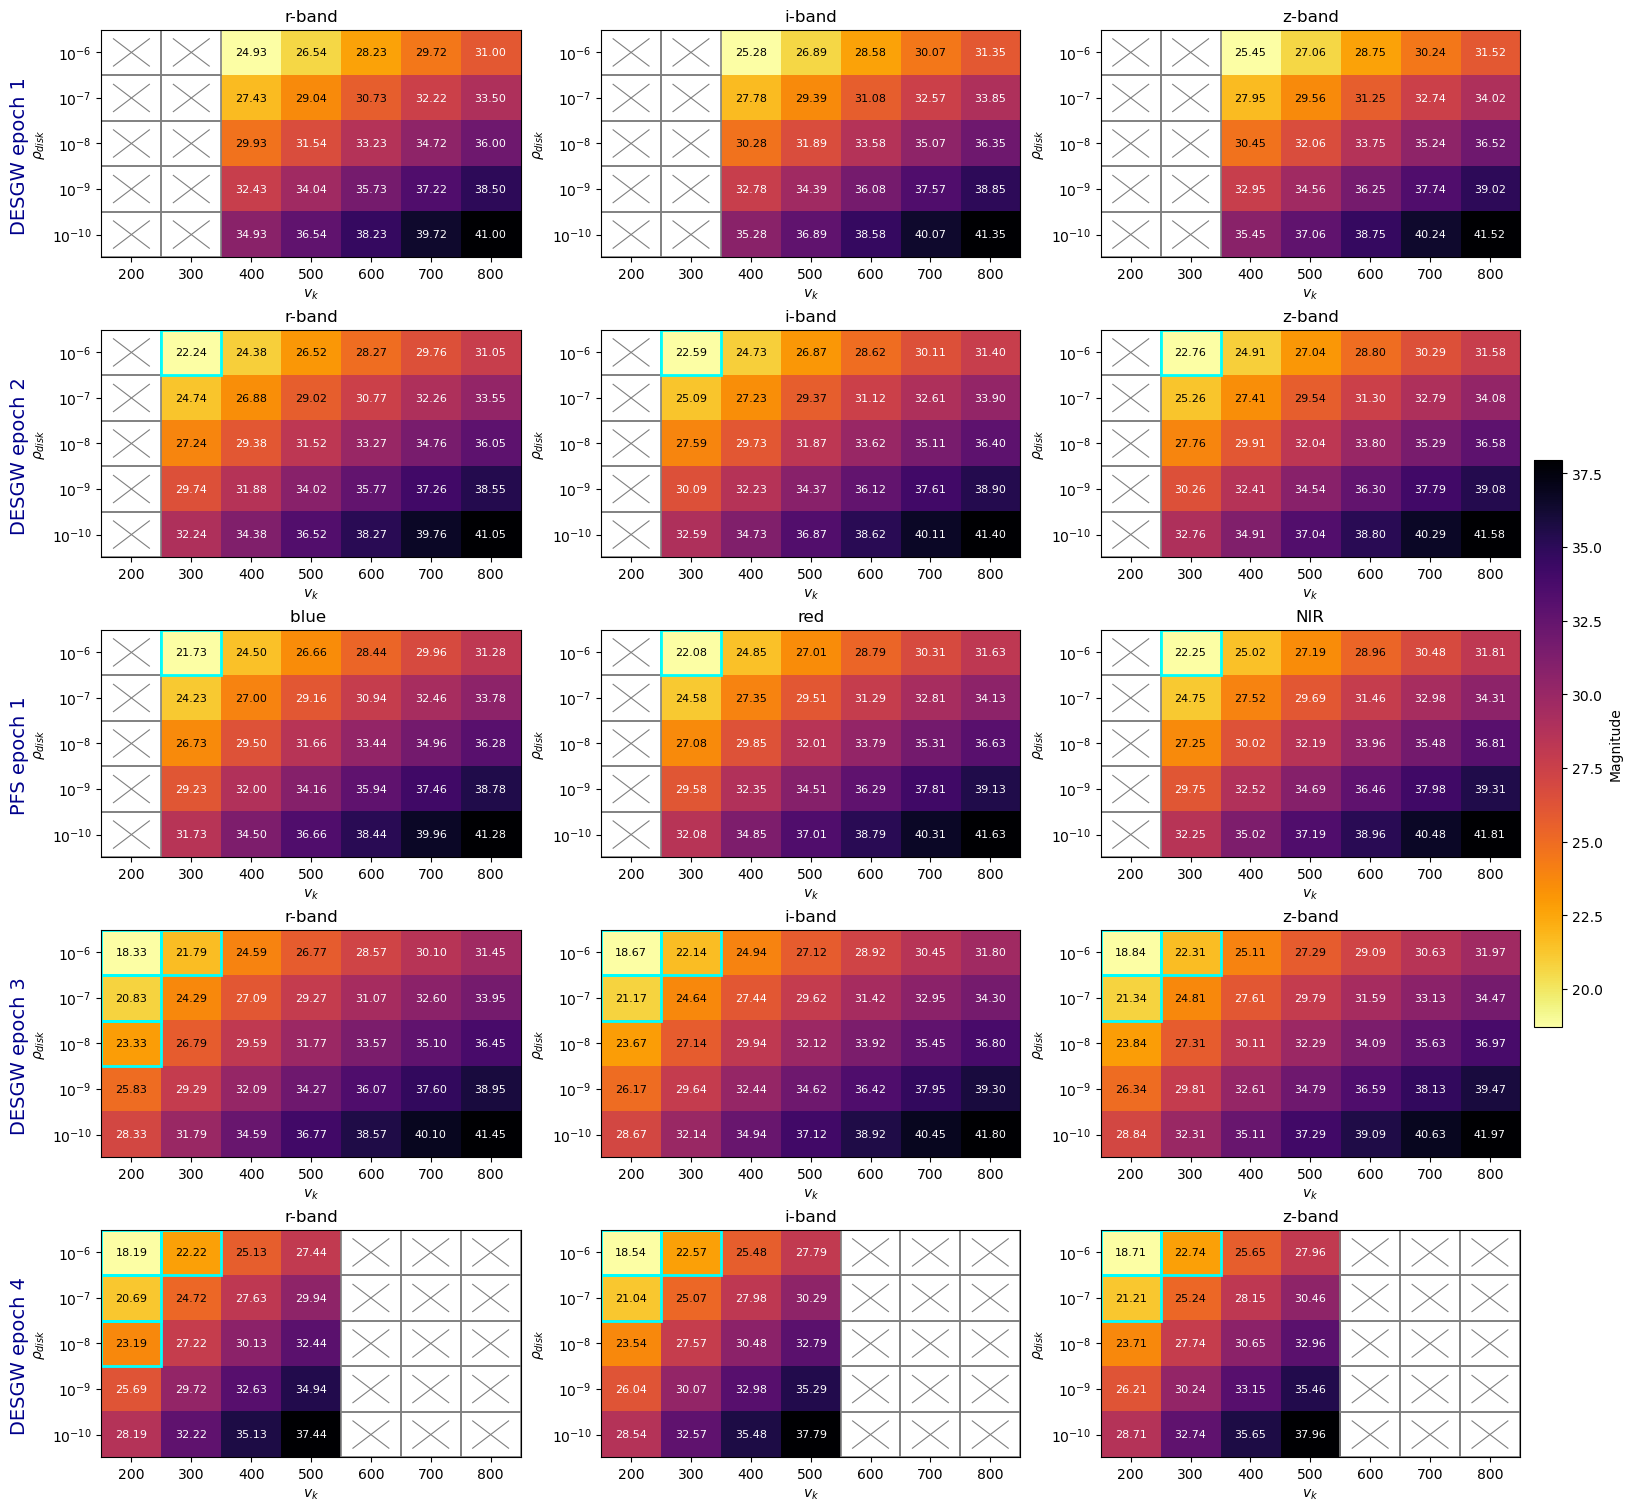

In [31]:
target_times = [1.0, 2.0, 6.0, 9.0, 28.0]
depths = {
    'r': [23.8, 23.8, 23.8, 23.8, 23.8],
    'i': [23.5, 23.5, 23.5, 23.5, 23.5],
    'z': [23.4, 23.4, 23.4, 23.4, 23.4]
}
bands = ['r', 'i', 'z']
tolerance = 0.2

vk_values = sorted(set(
    entry['params']['vk']
    for entry in model_dict.values()
    if isinstance(entry, dict) and 'params' in entry
))
rho_values = sorted(set(
    entry['params']['rho']
    for entry in model_dict.values()
    if isinstance(entry, dict) and 'params' in entry
))

# Filter rho and vk values to the range of interest
rho_min = 1e-10
rho_max = 1e-6
vk_min = 200
vk_max = 800
filtered_rho_values = [rho for rho in rho_values if rho_min <= rho <= rho_max]
filtered_vk_values = [vk for vk in vk_values if vk_min <= vk <= vk_max]

def format_rho(rho):
    exp = int(np.floor(np.log10(rho)))
    return f"$10^{{{exp}}}$"

fig, axes = plt.subplots(len(target_times), len(bands), figsize=(16, 3*len(target_times)), constrained_layout=True)

row_labels = ["DESGW epoch 1", "DESGW epoch 2", "PFS epoch 1", "DESGW epoch 3", "DESGW epoch 4"]

custom_titles = {
    'r': "blue ",
    'i': "red",
    'z': "NIR"
}

for t_idx, t in enumerate(target_times):
    for b_idx, band in enumerate(bands):
        mag_matrix = np.full((len(filtered_rho_values), len(filtered_vk_values)), np.nan, dtype=float)
        for model_id, model in model_dict.items():
            if isinstance(model, dict) and band in model:
                time_b, mag_b = model[band]
                idx = np.where(np.abs(time_b - t) < tolerance)[0]
                if len(idx) > 0:
                    vk = model['params']['vk']
                    rho = model['params']['rho']
                    mag = mag_b[idx[0]]
                    if (rho_min <= rho <= rho_max) and (vk_min <= vk <= vk_max):
                        i = filtered_rho_values.index(rho)
                        j = filtered_vk_values.index(vk)
                        mag_matrix[i, j] = mag

        ax = axes[t_idx, b_idx] if len(target_times) > 1 else axes[b_idx]
        im = ax.imshow(mag_matrix, origin='lower', aspect='auto', cmap='inferno_r')
        ax.set_xlabel(r'$v_k$')
        ax.set_ylabel(r'$\rho_{disk}$')
        # Set custom titles for PFS epoch row
        if t_idx == 2:
            ax.set_title(custom_titles[band])
        else:
            ax.set_title(f'{band}-band')
        ax.set_xticks(np.arange(len(filtered_vk_values)))
        ax.set_xticklabels([f"{val:.0f}" for val in filtered_vk_values])
        ax.set_yticks(np.arange(len(filtered_rho_values)))
        ax.set_yticklabels([format_rho(val) for val in filtered_rho_values])

        norm = plt.Normalize(np.nanmin(mag_matrix), np.nanmax(mag_matrix))
        cmap = cm.get_cmap('inferno_r')
        for i in range(len(filtered_rho_values)):
            for j in range(len(filtered_vk_values)):
                if not np.isnan(mag_matrix[i, j]):
                    mag = mag_matrix[i, j]
                    rgba = cmap(norm(mag))
                    brightness = 0.299*rgba[0] + 0.587*rgba[1] + 0.114*rgba[2]
                    text_color = 'white' if brightness < 0.5 else 'black'
                    ax.text(j, i, f"{mag:.2f}", ha='center', va='center', color=text_color, fontsize=8)
                    if mag < depths[band][t_idx]:
                        rect = patches.Rectangle((j-0.5, i-0.5), 1, 1, linewidth=2, edgecolor='cyan', facecolor='none', zorder=2)
                        ax.add_patch(rect)
                else:
                    # Draw a subtle, light gray cross (X) in the empty cell
                    ax.plot([j-0.3, j+0.3], [i-0.3, i+0.3], color='gray', lw=0.8, zorder=3)
                    ax.plot([j-0.3, j+0.3], [i+0.3, i-0.3], color='gray', lw=0.8, zorder=3)
                    # Draw the boundary of the box
                    rect = patches.Rectangle((j-0.5, i-0.5), 1, 1, linewidth=1.2, edgecolor='gray', facecolor='none', zorder=2)
                    ax.add_patch(rect)
    # Add row label (epoch) to the left of the row of subplots
    fig.text(0.001, 1 - (t_idx + 0.5) / len(target_times), row_labels[t_idx], va='center', ha='right', fontsize=14, color='darkblue', rotation=90)

fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.01, label='Magnitude')
plt.show()


Use PFS specific blackbody lightcurves for PFS epoch

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_95036/4174564521.py:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('inferno_r')
/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_95036/4174564521.py:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('inferno_r')
/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_95036/4174564521.py:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('inferno_r'

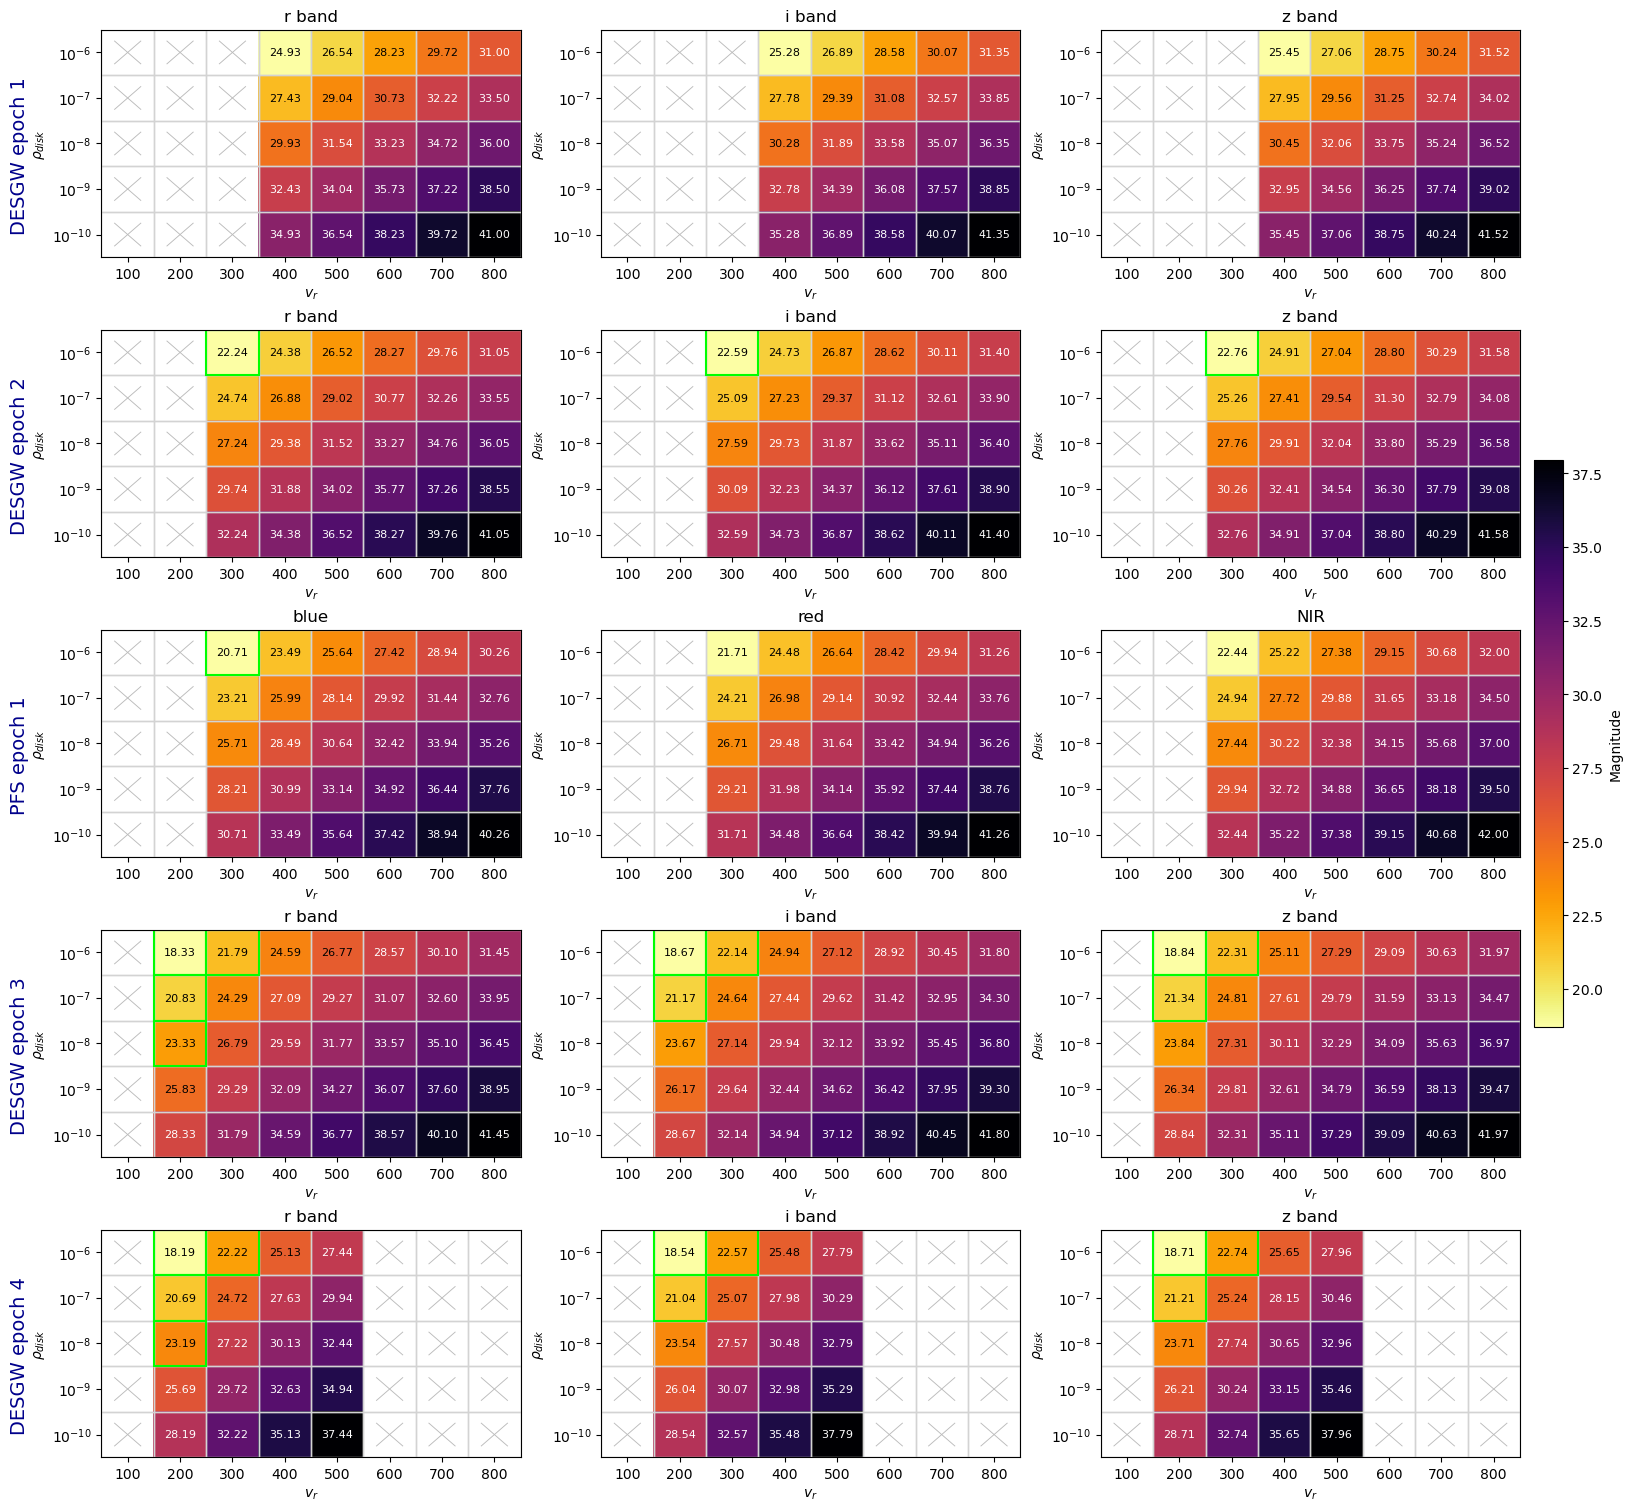

In [37]:
target_times = [1.0, 2.0, 6.0, 9.0, 28.0]
depths = {
    'r': [23.8, 23.8, None, 23.8, 23.8],
    'i': [23.5, 23.5, None, 23.5, 23.5],
    'z': [23.4, 23.4, None, 23.4, 23.4],
    'PFS_Blue': [None, None, 21.3, None, None],
    'PFS_Red': [None, None, 21.3, None, None],
    'PFS_NIR': [None, None, 19.6, None, None]
}
tolerance = 0.2

vk_min = 100
vk_max = 800
rho_min = 1e-10
rho_max = 1e-6

vk_values = sorted(set(
    entry['params']['vk']
    for entry in model_dict.values()
    if isinstance(entry, dict) and 'params' in entry
))
rho_values = sorted(set(
    entry['params']['rho']
    for entry in model_dict.values()
    if isinstance(entry, dict) and 'params' in entry
))

filtered_vk_values = [vk for vk in vk_values if vk_min <= vk <= vk_max]
filtered_rho_values = [rho for rho in rho_values if rho_min <= rho <= rho_max]

def format_rho(rho):
    exp = int(np.floor(np.log10(rho)))
    return f"$10^{{{exp}}}$"

fig, axes = plt.subplots(len(target_times), 3, figsize=(16, 3*len(target_times)), constrained_layout=True)

row_labels = ["DESGW epoch 1", "DESGW epoch 2", "PFS epoch 1", "DESGW epoch 3", "DESGW epoch 4"]

desgw_bands = ['r', 'i', 'z']
pfs_bands = ['PFS_Blue', 'PFS_Red', 'PFS_NIR']
desgw_titles = {'r': "r band", 'i': "i band", 'z': "z band"}
pfs_titles = {'PFS_Blue': "blue", 'PFS_Red': "red", 'PFS_NIR': "NIR"}

for t_idx, t in enumerate(target_times):
    # For the current row, select the correct bands and titles
    if t_idx == 2:
        bands = pfs_bands
        band_titles = pfs_titles
    else:
        bands = desgw_bands
        band_titles = desgw_titles
    for b_idx, band in enumerate(bands):
        mag_matrix = np.full((len(filtered_rho_values), len(filtered_vk_values)), np.nan, dtype=float)
        for model_id, model in model_dict.items():
            if isinstance(model, dict) and band in model:
                time_b, mag_b = model[band]
                idx = np.where(np.abs(time_b - t) < tolerance)[0]
                if len(idx) > 0:
                    vk = model['params']['vk']
                    rho = model['params']['rho']
                    mag = mag_b[idx[0]]
                    if (rho_min <= rho <= rho_max) and (vk_min <= vk <= vk_max):
                        i = filtered_rho_values.index(rho)
                        j = filtered_vk_values.index(vk)
                        mag_matrix[i, j] = mag

        ax = axes[t_idx, b_idx]
        im = ax.imshow(mag_matrix, origin='lower', aspect='auto', cmap='inferno_r')
        ax.set_xlabel(r'$v_r$')
        ax.set_ylabel(r'$\rho_{disk}$')
        ax.set_title(f"{band_titles[band]}", fontsize=12)
        ax.set_xticks(np.arange(len(filtered_vk_values)))
        ax.set_xticklabels([f"{val:.0f}" for val in filtered_vk_values])
        ax.set_yticks(np.arange(len(filtered_rho_values)))
        ax.set_yticklabels([format_rho(val) for val in filtered_rho_values])

        norm = plt.Normalize(np.nanmin(mag_matrix), np.nanmax(mag_matrix))
        cmap = cm.get_cmap('inferno_r')

        for i in range(len(filtered_rho_values)):
            for j in range(len(filtered_vk_values)):
                rect = patches.Rectangle((j-0.5, i-0.5), 1, 1, linewidth=1, edgecolor='lightgray', facecolor='none', zorder=1)
                ax.add_patch(rect)
                if not np.isnan(mag_matrix[i, j]):
                    mag = mag_matrix[i, j]
                    rgba = cmap(norm(mag))
                    brightness = 0.299 * rgba[0] + 0.587 * rgba[1] + 0.114 * rgba[2]
                    text_color = 'white' if brightness < 0.5 else 'black'
                    ax.text(j, i, f"{mag:.2f}", ha='center', va='center', color=text_color, fontsize=8)
                    if mag < depths[band][t_idx]:
                        rect = patches.Rectangle((j-0.5, i-0.5), 1, 1, linewidth=1.5, edgecolor='lime', facecolor='none', zorder=2)
                        ax.add_patch(rect)
                else:
                    # Draw a very faint cross (X) in the empty cell for visual cue
                    ax.plot([j-0.25, j+0.25], [i-0.25, i+0.25], color='#bbbbbb', lw=0.65, zorder=3)
                    ax.plot([j-0.25, j+0.25], [i+0.25, i-0.25], color='#bbbbbb', lw=0.65, zorder=3)
    # Add row label (epoch) to the left of the row of subplots
    fig.text(0.001, 1 - (t_idx + 0.5) / len(target_times), row_labels[t_idx], va='center', ha='right', fontsize=14, color='darkblue', rotation=90)

fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.01, label='Magnitude')


plt.savefig('lightcurve_heatmaps_DECam_PFS.jpeg', dpi=300)
plt.show()